## Prepare data

Let's begin by creating an example image. We will use the Shepp-Logan phantom, provided by [`scikit-image`](https://pypi.org/project/scikit-image/).

In [1]:
import skimage.data
import skimage.transform
import tensorflow as tf

grid_shape = [256, 256]
image = tf.convert_to_tensor(skimage.transform.resize(
    skimage.data.shepp_logan_phantom(), grid_shape).astype('float32'), dtype=tf.complex64)

print("image: \n - shape: {}\n - dtype: {}".format(image.shape, image.dtype))

image: 
 - shape: (256, 256)
 - dtype: <dtype: 'complex64'>


Let us also create a k-space trajectory. In this example we will create a radial trajectory using the [`tensorflow-mri`](https://pypi.org/project/tensorflow-mri/) package, but you can create your own trajectories.

In [2]:
import tensorflow_mri as tfmr

points = tfmr.radial_trajectory(base_resolution=256, views=233)
points = tf.reshape(points, [-1, 2])

print("points: \n - shape: {}\n - dtype: {}\n - range: [{}, {}]".format(
    points.shape, points.dtype, tf.math.reduce_min(points), tf.math.reduce_max(points)))

points: 
 - shape: (119296, 2)
 - dtype: <dtype: 'float32'>
 - range: [-3.141521453857422, 3.1415927410125732]


Note that the trajectory should have shape `[..., M, N]`, where `M` is the number of points and `N` is the number of dimensions. Any additional outer dimensions will be treated as batch dimensions. Note that batch dimensions for `image` and `traj` will be automatically broadcasted.

In addition, note that spatial frequencies should be provided in radians/voxel, ie, in the range `[-pi, pi]`.

Finally, we'll also need density compensation weights for our set of nonuniform points. These are necessary in the adjoint transform, to compensate for the fact that the sampling density in a radial trajectory is not uniform. Here we use the `tensorflow-mri` package to calculate these weights.

In [3]:
weights = tfmr.radial_density(base_resolution=256, views=233)
weights = tf.reshape(weights, [-1])

print("weights: \n - shape: {}\n - dtype: {}".format(weights.shape, weights.dtype))

weights: 
 - shape: (119296,)
 - dtype: <dtype: 'float32'>


## Forward transform (image to k-space)

Next, let's calculate the k-space coefficients for the given image and trajectory points (image to k-space transform).

In [4]:
import tensorflow_nufft as tfft

kspace = tfft.nufft(image, points, transform_type='type_2', j_sign='negative')

print("kspace: \n - shape: {}\n - dtype: {}".format(kspace.shape, kspace.dtype))

kspace: 
 - shape: (119296,)
 - dtype: <dtype: 'complex64'>


We are using a `'type_2'` transform (uniform to nonuniform) and a `'negative'` sign for the imaginary unit (signal domain to frequency domain). These are the default values for `transform_type` and `j_sign`, so it was not necessary to provide them in this case.

## Adjoint transform (k-space to image)

In [5]:
# Apply density compensation.
comp_kspace = kspace / tf.cast(weights, tf.complex64)

recon = tfft.nufft(comp_kspace, points, transform_type='type_1', j_sign='positive', grid_shape=grid_shape)

print("recon: \n - shape: {}\n - dtype: {}".format(recon.shape, recon.dtype))

recon: 
 - shape: (256, 256)
 - dtype: <dtype: 'complex64'>


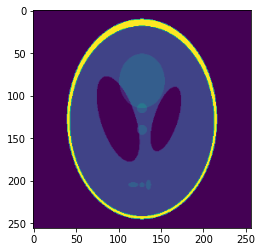

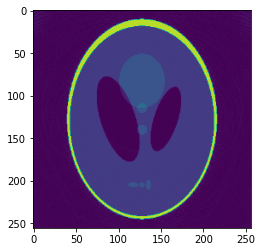

In [6]:
import matplotlib.pyplot as plt

plt.imshow(tf.abs(image))
plt.show()

plt.imshow(tf.abs(recon))
plt.show()
